Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

=== Evaluation on Test Set ===
Accuracy : 0.6948
Precision: 0.5745
Recall   : 0.5000
F1-score : 0.5347
ROC AUC  : 0.8128

Classification report:

              precision    recall  f1-score   support

           0     0.7477    0.8000    0.7729       100
           1     0.5745

/tmp/ipython-input-1049224190.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)


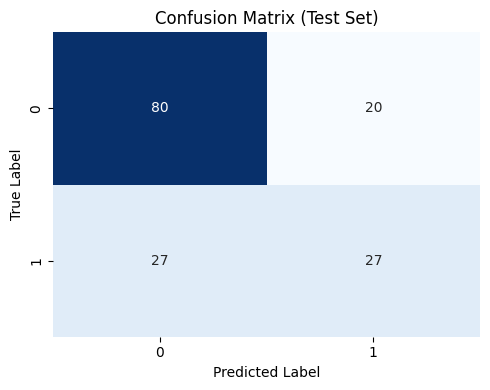

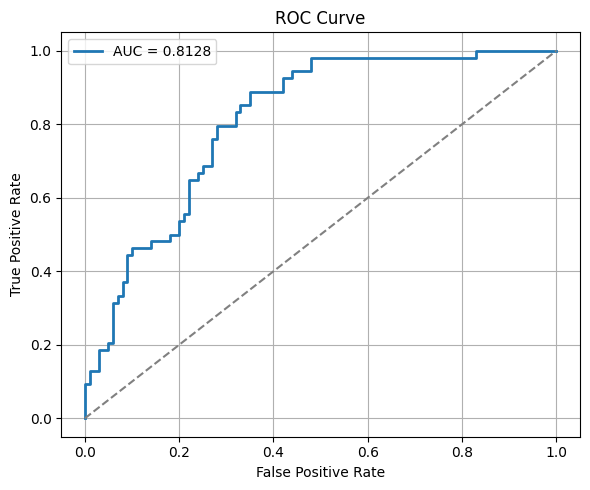

5-fold CV ROC AUC scores: [0.825      0.86722222 0.85148148 0.82943396 0.80962264]
Mean CV AUC: 0.8366

Saved:
- confusion_matrix.png
- roc_curve.png
- artifacts/logistic_model.joblib
- artifacts/scaler.joblib
- artifacts/metrics.txt


In [1]:
# === Logistic Regression on Pima Indians Diabetes


!pip install -q joblib

# 1) Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 2) Load dataset (public UCI mirror, no Kaggle login required)
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]

df = pd.read_csv(URL, header=None, names=cols)
print("Dataset shape:", df.shape)
print(df.head())

# 3) Handle invalid zeros (replace with NaN)
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Fill NaNs with median values
for c in cols_with_zeros:
    df[c].fillna(df[c].median(), inplace=True)

# 4) Features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# 5) Train/test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6) Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7) Train logistic regression model
clf = LogisticRegression(solver="liblinear", penalty="l2", random_state=42)
clf.fit(X_train_scaled, y_train)

# 8) Predictions
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

# 9) Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Evaluation on Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}\n")

print("Classification report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 10) Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# 11) ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

# 12) Cross-Validation (5-fold ROC AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, scaler.fit_transform(X), y, cv=cv, scoring="roc_auc")
print("5-fold CV ROC AUC scores:", cv_scores)
print("Mean CV AUC: {:.4f}".format(cv_scores.mean()))

# 13) Save artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(clf, "artifacts/logistic_model.joblib")
joblib.dump(scaler, "artifacts/scaler.joblib")

with open("artifacts/metrics.txt", "w") as f:
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"Precision: {prec:.4f}\n")
    f.write(f"Recall: {rec:.4f}\n")
    f.write(f"F1: {f1:.4f}\n")
    f.write(f"ROC AUC: {auc:.4f}\n")
    f.write("5-fold CV AUCs: " + ", ".join([f"{s:.4f}" for s in cv_scores]) + "\n")

print("\nSaved:")
print("- confusion_matrix.png")
print("- roc_curve.png")
print("- artifacts/logistic_model.joblib")
print("- artifacts/scaler.joblib")
print("- artifacts/metrics.txt")
